In [2]:
import pandas as pd

sep = "\n------------------------------------------------------------------------------------------------------------------------------------------\n\n"
initialData = pd.read_csv("Global_Education.csv", encoding='iso-8859-1')

print(sep, "~  Data Exploration and Cleaning ~\n", sep, "Raw Data:\n\n" )
print(initialData.info(), sep) # befor cleaning

df = initialData.iloc[1:, 1:].astype(float)  # convert all numeric data to same datatype beside titles
df.insert(0, "Countries and areas", initialData["Countries and areas"], True ) # merge dataset
initialShape = initialData.shape

df.drop_duplicates()
dfTemp = df.drop(columns=['Countries and areas', 'Latitude ', 'Longitude','Birth_Rate', 'Gross_Primary_Education_Enrollment', 'Gross_Tertiary_Education_Enrollment', 'Unemployment_Rate'])  # drop incorrect data
dfC = dfTemp[(dfTemp.T != 0).any()]
dfC.dropna()
dfC.insert(0, "Countries and areas", initialData["Countries and areas"], True )
dfC = dfC.assign(**df[['Birth_Rate', 'Gross_Primary_Education_Enrollment', 'Gross_Tertiary_Education_Enrollment', 'Unemployment_Rate']])

print(f"DataFrame Shape: {initialShape}.\nCleaned DataFrame shape: {dfC.shape}\n")

original_countries = set(initialData['Countries and areas']) # Checking which countries we've removed during the cleaning level
cleaned_countries = set(dfC['Countries and areas'])
removed_countries = original_countries - cleaned_countries
print("Countries removed during cleaning:", list(removed_countries),'\n', sep)
print(dfC.info(), sep)


------------------------------------------------------------------------------------------------------------------------------------------

 ~  Data Exploration and Cleaning ~
 
------------------------------------------------------------------------------------------------------------------------------------------

 Raw Data:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Countries and areas                      202 non-null    object 
 1   Latitude                                 202 non-null    float64
 2   Longitude                                202 non-null    float64
 3   OOSR_Pre0Primary_Age_Male                202 non-null    int64  
 4   OOSR_Pre0Primary_Age_Female              202 non-null    int64  
 5   OOSR_Primary_Age_Male                    202 non-null    int64  
 6 

In [ ]:
# Helper functions for analysis
import re

def add_all_gender_disparities(df, male_suffix='_Male', female_suffix='_Female'):  # create new data set with all dispairity calculations
    new_df = df.copy()
    pattern = re.compile(rf'(.*){male_suffix}$')  # Regular expression pattern to identify male and female pairs
    male_columns = [col for col in df.columns if col.endswith(male_suffix)]

    for male_col in male_columns:
        baseName = pattern.match(male_col)  # Extract the base name of the column
        if not baseName:
            continue

        base_name = baseName.group(1)
        female_col = base_name + female_suffix

        if female_col in df.columns:
            # Create the new disparity column name and calculate
            disparity_col = base_name + '_GenderDisparity'
            new_df[disparity_col] = abs(new_df[male_col] - new_df[female_col])

    return new_df



disparities = add_all_gender_disparities(dfC)
disparities.to_csv('dispairities.csv')


In [ ]:

def addSpecificGenderDisparity(data, male_column, female_column, disparity_column_name):
    df = data.copy() # Ensure you're not modifying the original DataFrame
    df[disparity_column_name] = abs(df[male_column] - df[female_column])
    return df

# Calculate gender disparity for primary completion rate
print("~ Calculating Gender Disparity for Completion Rate In Primary Schoole ~", sep)
disData = addSpecificGenderDisparity(dfC, male_column='Completion_Rate_Primary_Male', female_column='Completion_Rate_Primary_Female', disparity_column_name='Completion_Rate_Primary_GenderDisparity')
print(disData.shape , disData.info())


~ Calculating Gender Disparity for Completion Rate In Primary Schoole ~ 
------------------------------------------------------------------------------------------------------------------------------------------


<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 1 to 201
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Countries and areas                      196 non-null    object 
 1   OOSR_Pre0Primary_Age_Male                196 non-null    float64
 2   OOSR_Pre0Primary_Age_Female              196 non-null    float64
 3   OOSR_Primary_Age_Male                    196 non-null    float64
 4   OOSR_Primary_Age_Female                  196 non-null    float64
 5   OOSR_Lower_Secondary_Age_Male            196 non-null    float64
 6   OOSR_Lower_Secondary_Age_Female          196 non-null    float64
 7   OOSR_Upper_Secondary_Age_Male            196 non-nu

In [ ]:
disData[["Completion_Rate_Primary_Male","Completion_Rate_Primary_Female", "Completion_Rate_Primary_GenderDisparity"]]

,Completion_Rate_Primary_Male,Completion_Rate_Primary_Female,Completion_Rate_Primary_GenderDisparity
1,94.0,96.0,2.0
2,93.0,93.0,0.0
4,63.0,57.0,6.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
...,...,...,...
197,0.0,0.0,0.0
198,96.0,97.0,1.0
199,70.0,55.0,15.0
200,71.0,73.0,2.0


In [ ]:
def top3Disparity(df, suffix='_GenderDisparity'):
    disparityCol = [col for col in df.columns if col.endswith(suffix)]
    columnSum = df[disparityCol].sum()
    top3 = columnSum.nlargest(3)

    return top3

top3Disparity(disparities)


OOSR_Upper_Secondary_Age_GenderDisparity           719.0
Completion_Rate_Upper_Secondary_GenderDisparity    700.0
Completion_Rate_Lower_Secondary_GenderDisparity    632.0
dtype: float64

In [ ]:
temp1 = addSpecificGenderDisparity(disData, male_column='OOSR_Upper_Secondary_Age_Male', female_column='OOSR_Upper_Secondary_Age_Female', disparity_column_name='OOSR_Upper_Secondary_Age_GenderDisparity')
temp2 = addSpecificGenderDisparity(temp1, male_column='Completion_Rate_Upper_Secondary_Male', female_column='Completion_Rate_Upper_Secondary_Female', disparity_column_name='Completion_Rate_Upper_Secondary_GenderDisparity')
data = addSpecificGenderDisparity(temp2, male_column='Completion_Rate_Lower_Secondary_Male', female_column='Completion_Rate_Lower_Secondary_Female', disparity_column_name='Completion_Rate_Lower_Secondary_GenderDisparity')
data.columns


Index(['Countries and areas', 'OOSR_Pre0Primary_Age_Male',
       'OOSR_Pre0Primary_Age_Female', 'OOSR_Primary_Age_Male',
       'OOSR_Primary_Age_Female', 'OOSR_Lower_Secondary_Age_Male',
       'OOSR_Lower_Secondary_Age_Female', 'OOSR_Upper_Secondary_Age_Male',
       'OOSR_Upper_Secondary_Age_Female', 'Completion_Rate_Primary_Male',
       'Completion_Rate_Primary_Female',
       'Completion_Rate_Lower_Secondary_Male',
       'Completion_Rate_Lower_Secondary_Female',
       'Completion_Rate_Upper_Secondary_Male',
       'Completion_Rate_Upper_Secondary_Female',
       'Grade_2_3_Proficiency_Reading', 'Grade_2_3_Proficiency_Math',
       'Primary_End_Proficiency_Reading', 'Primary_End_Proficiency_Math',
       'Lower_Secondary_End_Proficiency_Reading',
       'Lower_Secondary_End_Proficiency_Math',
       'Youth_15_24_Literacy_Rate_Male', 'Youth_15_24_Literacy_Rate_Female',
       'Birth_Rate', 'Gross_Primary_Education_Enrollment',
       'Gross_Tertiary_Education_Enrollment', 'Unemp


------------------------------------------------------------------------------------------------------------------------------------------

 ~ Initial Exploratory Data Analysis - EDA ~ 




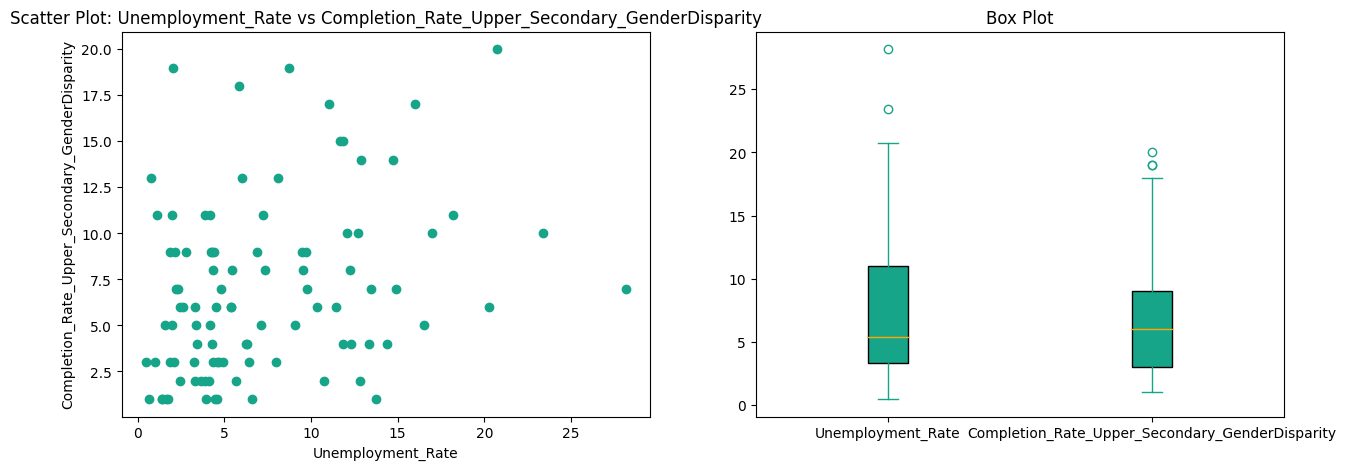

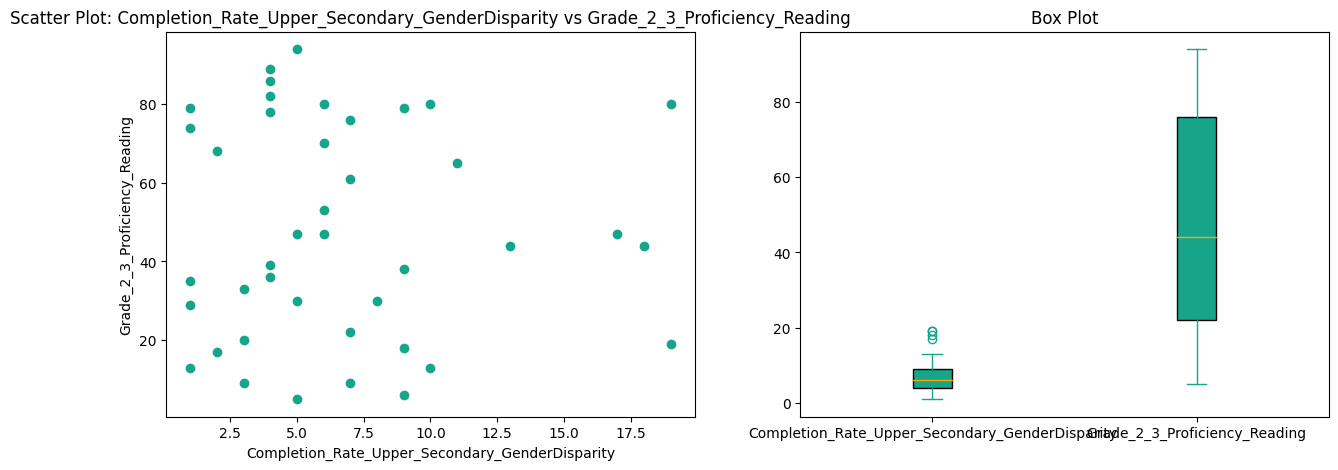

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_correlations_single_pair(dataframe, column1, column2):
    # Clean the dataframe from rows where either column has zero values
    cleaned_df = dataframe[(dataframe[column1] != 0) & (dataframe[column2] != 0)]

    for col in data.columns: # Clean the dataset by dropping non-numeric columns
        if not np.issubdtype(data[col].dtype, np.number):
            data.drop(col, axis=1, inplace=True)

    # Define colors for the plots
    color_for_plot = "#17A589"
    median_color = "#FFA500"  # Orange color for the median line

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Scatter plot
    ax[0].scatter(cleaned_df[column1], cleaned_df[column2], c=color_for_plot)
    ax[0].set_title(f'Scatter Plot: {column1} vs {column2}')
    ax[0].set_xlabel(column1)
    ax[0].set_ylabel(column2)

    # Box plot
    ax[1].boxplot([cleaned_df[column1], cleaned_df[column2]], patch_artist=True,
                  boxprops=dict(facecolor=color_for_plot),
                  whiskerprops=dict(color=color_for_plot),
                  capprops=dict(color=color_for_plot),
                  flierprops=dict(markeredgecolor=color_for_plot),
                  medianprops=dict(color=median_color))  # Orange color for median
    ax[1].set_title('Box Plot')
    ax[1].set_xticklabels([column1, column2])

    plt.show()


column_pairs = [
    ("Unemployment_Rate", "Completion_Rate_Upper_Secondary_GenderDisparity"),
    ("Completion_Rate_Upper_Secondary_GenderDisparity", "Grade_2_3_Proficiency_Reading")
]

print(sep, "~ Initial Exploratory Data Analysis - EDA ~ \n\n")
for col1, col2 in column_pairs:
    plot_correlations_single_pair(data, col1, col2)



------------------------------------------------------------------------------------------------------------------------------------------

 ~ Hypothesis Formulation ~


Pearson Correlation: 0.28235645696167194, P-value: 6.0821855595067085e-05


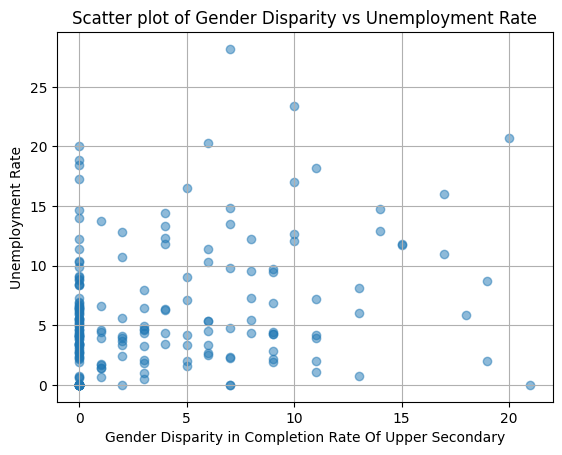

The correlation between gender disparity in primary education and unemployment rate is statistically significant.


In [ ]:
import scipy.stats as stats
# היפוטזה --> למדינות עם פער גדול יותר בין המינים בהשלמת לימודי התיכון יש שיעורי אבטלה גבוהים יותר

gender_disparity = data['Completion_Rate_Upper_Secondary_GenderDisparity']
unemployment_rate = data['Unemployment_Rate']
gender_disparity = gender_disparity.dropna()
unemployment_rate = unemployment_rate.dropna()

print(sep, "~ Hypothesis Formulation ~\n\n")

# Pearson correlation test
correlation, p_value = stats.pearsonr(gender_disparity, unemployment_rate)
print(f'Pearson Correlation: {correlation}, P-value: {p_value}')

plt.scatter(gender_disparity, unemployment_rate, alpha=0.5)
plt.title('Scatter plot of Gender Disparity vs Unemployment Rate')
plt.xlabel('Gender Disparity in Completion Rate Of Upper Secondary')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()


if p_value < 0.05:
    print("The correlation between gender disparity in primary education and unemployment rate is statistically significant.")
else:
    print("No significant correlation was found between gender disparity in primary education and unemployment rate.")


# Given these results, we can conclude that there is a statistically significant,
# though weak, positive correlation between the variables.
# This means that while there is a relationship, it is not particularly strong.
# The statistical significance implies that the findings are not random,
# but the weak correlation coefficient indicates that the effect size of the relationship is minimal.

                            OLS Regression Results                            
Dep. Variable:      Unemployment_Rate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     9.241
Date:                Sun, 12 May 2024   Prob (F-statistic):            0.00326
Time:                        16:21:35   Log-Likelihood:                -239.80
No. Observations:                  77   AIC:                             483.6
Df Residuals:                      75   BIC:                             488.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

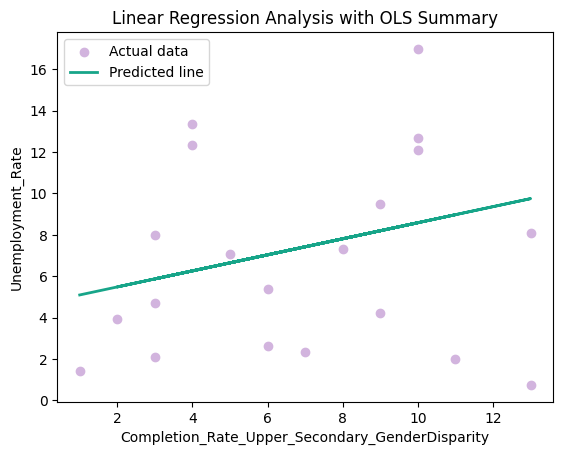

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


feature_column = 'Completion_Rate_Upper_Secondary_GenderDisparity'
target_column = 'Unemployment_Rate'
dataReg = data[(data[feature_column] != 0) & (data[target_column] != 0)]

X = dataReg[[feature_column]]  # Features
y = dataReg[target_column]  # Target variable
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())  #  OLS regression results
y_pred = results.predict(X_test)

# Mean Squared Error and the R-squared value for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}', sep)

print(sep, "~ Linear Regression Analysis ~\n\n")
plt.scatter(X_test[feature_column], y_test, color='#D2B4DE', label='Actual data')
plt.plot(X_test[feature_column], y_pred, color='#17A589', linewidth=2, label='Predicted line')
plt.title('Linear Regression Analysis with OLS Summary')
plt.xlabel(feature_column)
plt.ylabel(target_column)
plt.legend()
plt.show()


In [ ]:

variables = ["Gross_Tertiary_Education_Enrollment", "Birth_Rate", "Gross_Primary_Education_Enrollment"]

#  correlation coefficients
correlation_tertiary_birth = data['Gross_Tertiary_Education_Enrollment'].corr(data['Birth_Rate'])
correlation_tertiary_primary = data['Gross_Tertiary_Education_Enrollment'].corr(data['Gross_Primary_Education_Enrollment'])

print(sep, "~ Correlation Analysis ~")
print(f"Correlation between Tertiary Education Enrollment and Birth Rate: {correlation_tertiary_birth}")
print(f"Correlation between Tertiary Education Enrollment and Primary Education Enrollment: {correlation_tertiary_primary}")

t_stat_birth, p_value_birth = stats.pearsonr(data['Gross_Tertiary_Education_Enrollment'], data['Birth_Rate'])
t_stat_primary, p_value_primary = stats.pearsonr(data['Gross_Tertiary_Education_Enrollment'], data['Gross_Primary_Education_Enrollment'])

print(sep, f"P-value for correlation with Birth Rate: {p_value_birth}")
print(f"P-value for correlation with Primary Education Enrollment: {p_value_primary}", sep)

alpha = 0.05  # significance level
if p_value_birth < alpha:
    print("Reject the null hypothesis for correlation with Birth Rate, suggesting a significant correlation.")
else:
    print("Fail to reject the null hypothesis for correlation with Birth Rate, suggesting no significant correlation.")

if p_value_primary < alpha:
    print("Reject the null hypothesis for correlation with Primary Education Enrollment, suggesting a significant correlation.")
else:
    print("Fail to reject the null hypothesis for correlation with Primary Education Enrollment, suggesting no significant correlation.")



------------------------------------------------------------------------------------------------------------------------------------------

 ~ Correlation Analysis ~
Correlation between Tertiary Education Enrollment and Birth Rate: -0.4835837982140345
Correlation between Tertiary Education Enrollment and Primary Education Enrollment: 0.2571512192167223

------------------------------------------------------------------------------------------------------------------------------------------

 P-value for correlation with Birth Rate: 6.986902812232353e-13
P-value for correlation with Primary Education Enrollment: 0.00027426375809672706 
------------------------------------------------------------------------------------------------------------------------------------------


Reject the null hypothesis for correlation with Birth Rate, suggesting a significant correlation.
Reject the null hypothesis for correlation with Primary Education Enrollment, suggesting a significant correlation.


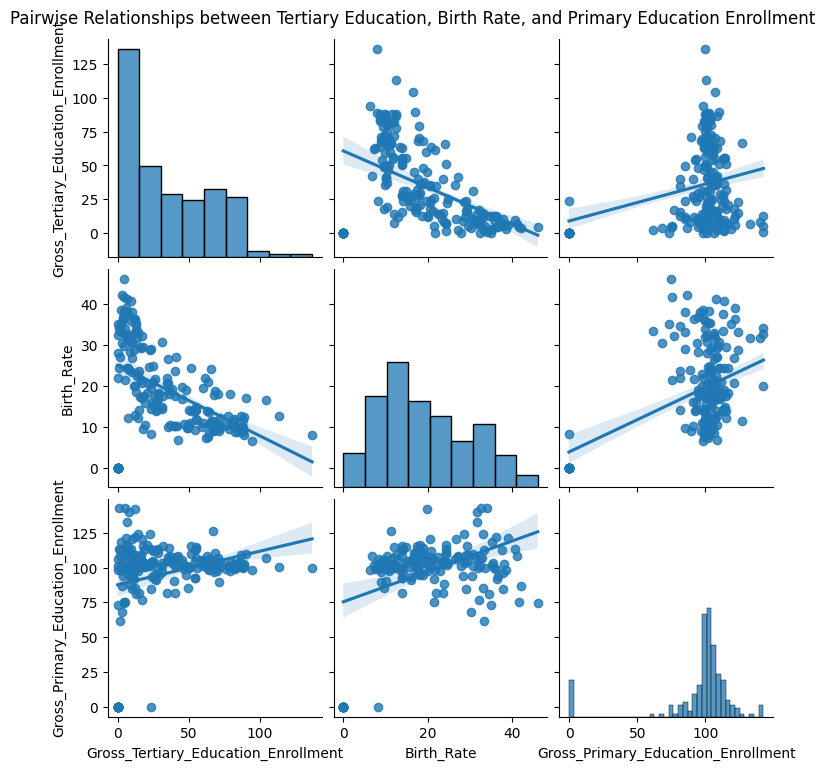

In [ ]:
import seaborn as sns
# Conclusion
# The analysis demonstrates a statistically significant negative correlation between Tertiary Education Enrollment and Birth Rate (correlation coefficient = -0.4548, p-value < 0.00001),
# suggesting that regions with higher tertiary education enrollment tend to have lower birth rates. Additionally, there is a statistically significant positive correlation between Tertiary Education Enrollment and Primary Education Enrollment (correlation coefficient = 0.2840, p-value < 0.00005), indicating that higher tertiary enrollment is associated with higher primary education enrollment.
# These results support a substantial relationship between education levels and demographic factors, potentially influencing policy decisions.


sns.pairplot(data, vars=['Gross_Tertiary_Education_Enrollment', 'Birth_Rate', 'Gross_Primary_Education_Enrollment'], kind='reg')
plt.suptitle('Pairwise Relationships between Tertiary Education, Birth Rate, and Primary Education Enrollment', y=1.02)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


data['rate_binned'] = pd.qcut(data['Unemployment_Rate'], q=4, labels=False)
label_encoder = LabelEncoder()
data['rate_class'] = label_encoder.fit_transform(data['rate_binned'])

# Select features and the target variable
X = data.drop(['Unemployment_Rate', 'rate_binned', 'rate_class'], axis=1)  # or select columns manually if necessary
y = data['rate_class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize classifiers
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

# Train the classifiers
dt_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_classifier.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the models
print("Decision Tree Metrics:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("Precision:", precision_score(y_test, dt_predictions, average='macro'))
print("Recall:", recall_score(y_test, dt_predictions, average='macro'))
print("F1 Score:", f1_score(y_test, dt_predictions, average='macro'))

print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions, average='macro'))
print("Recall:", recall_score(y_test, rf_predictions, average='macro'))
print("F1 Score:", f1_score(y_test, rf_predictions, average='macro'))



Decision Tree Metrics:
Accuracy: 0.3728813559322034
Precision: 0.39027883880825054
Recall: 0.36343460461107513
F1 Score: 0.3623150424137266

Random Forest Metrics:
Accuracy: 0.3050847457627119
Precision: 0.31510929730743975
Recall: 0.30955613014436545
F1 Score: 0.30789657353486444
